# Conditional Variational Auto Encoder

In [25]:
from keras.layers import Lambda, Input, Dense
from keras.layers import Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate
from keras.models import Model
from keras import metrics
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [46]:
# hyper parameters
input_shape = (28, 28, 1)
num_classes = 10
intermediate_dim = 300
latent_dim = 50
epochs = 200
batch_size = 128
labeled_num = 100
unlabeled_num = 60000 - 100
steps_per_epoch = unlabeled_num // batch_size + 1

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [28]:
# layersリストの中にさらにリストがあっても、ネットワークがつながる。
def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [29]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [30]:
#########
# Input layer
#########
x_in = Input(shape=input_shape, name='input')
y_in = Input(shape=(num_classes,), name='label_input')


########
# encoder
########
x = Flatten()(x_in)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(x_in, [z_mean, z_log_var, z], name='encoder')

########
# classifier
########
classifier_layers = [
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
]
y_output = inst_layers(classifier_layers, x_in)
classifier = Model(x_in, y_output, name='classifier')

########
# decoder
########
decoder_layers = [
    Dense(intermediate_dim, activation='relu'),
    Dense(7*7*32, activation='relu'),
    Reshape((7, 7, 32)),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2DTranspose(filters=1, kernel_size=1, strides=1, activation='sigmoid', padding='same'),
]
# labeled decoder
merged = concatenate([y_in, z])
x_out = inst_layers(decoder_layers, merged)
# Unlabeled decoder
u_merged = concatenate([y_output, z])
u_x_out = inst_layers(decoder_layers, u_merged)

## Loss function

In [31]:
def kl_loss(x, x_decoded_mean, z_mean=z_mean, z_log_var=z_log_var):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logxy_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = np.prod(input_shape) * metrics.binary_crossentropy(x, x_decoded_mean)
   
    # p(y) for observed data is equally distributed
    logy = np.log(1. / num_classes)
    
    return xent_loss - logy

def labeled_vae_loss(x, x_decoded_mean):
    return logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

def cls_loss(y, y_pred, N=1000):
    alpha = 0.1 * N
    return alpha * metrics.categorical_crossentropy(y, y_pred)

def unlabeled_vae_loss(x, x_decoded_mean):
    entropy = metrics.categorical_crossentropy(y_output, y_output)
    labeled_loss = logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    
    return K.mean(K.sum(y_output * labeled_loss, axis=-1)) + entropy

In [32]:
# instantiate C-VAE model
# x_out = decoder([y_in, encoder(encoder_input)[2]])
labeled_vae = Model([x_in, y_in], [x_out, y_output], name='label_c_vae')
unlabeled_vae = Model(x_in, u_x_out, name='unlabel_c_vae')

labeled_vae.compile(optimizer='adam', loss=[labeled_vae_loss, cls_loss])
unlabeled_vae.compile(optimizer='adam', loss=[unlabeled_vae_loss])

In [33]:
plot_model(labeled_vae, to_file='label_c_vae_model.png', show_shapes=True)
plot_model(unlabeled_vae, to_file='unlabel_c_vae_model.png', show_shapes=True)

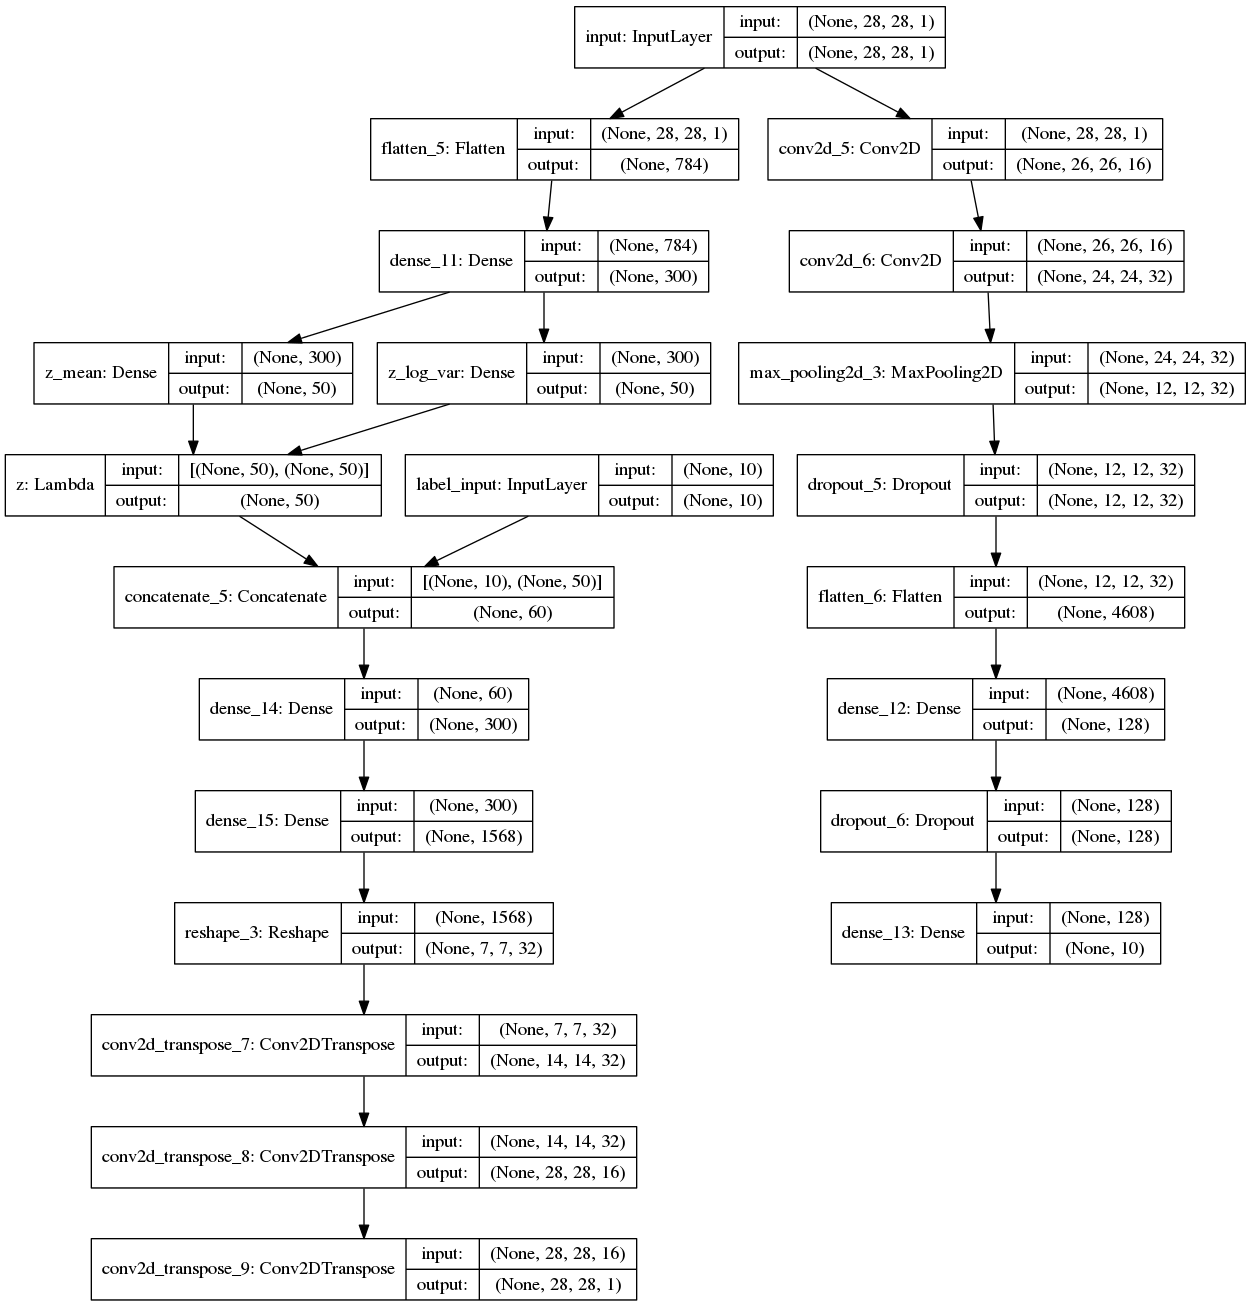

In [34]:
from keras.preprocessing.image import load_img
load_img('label_c_vae_model.png')

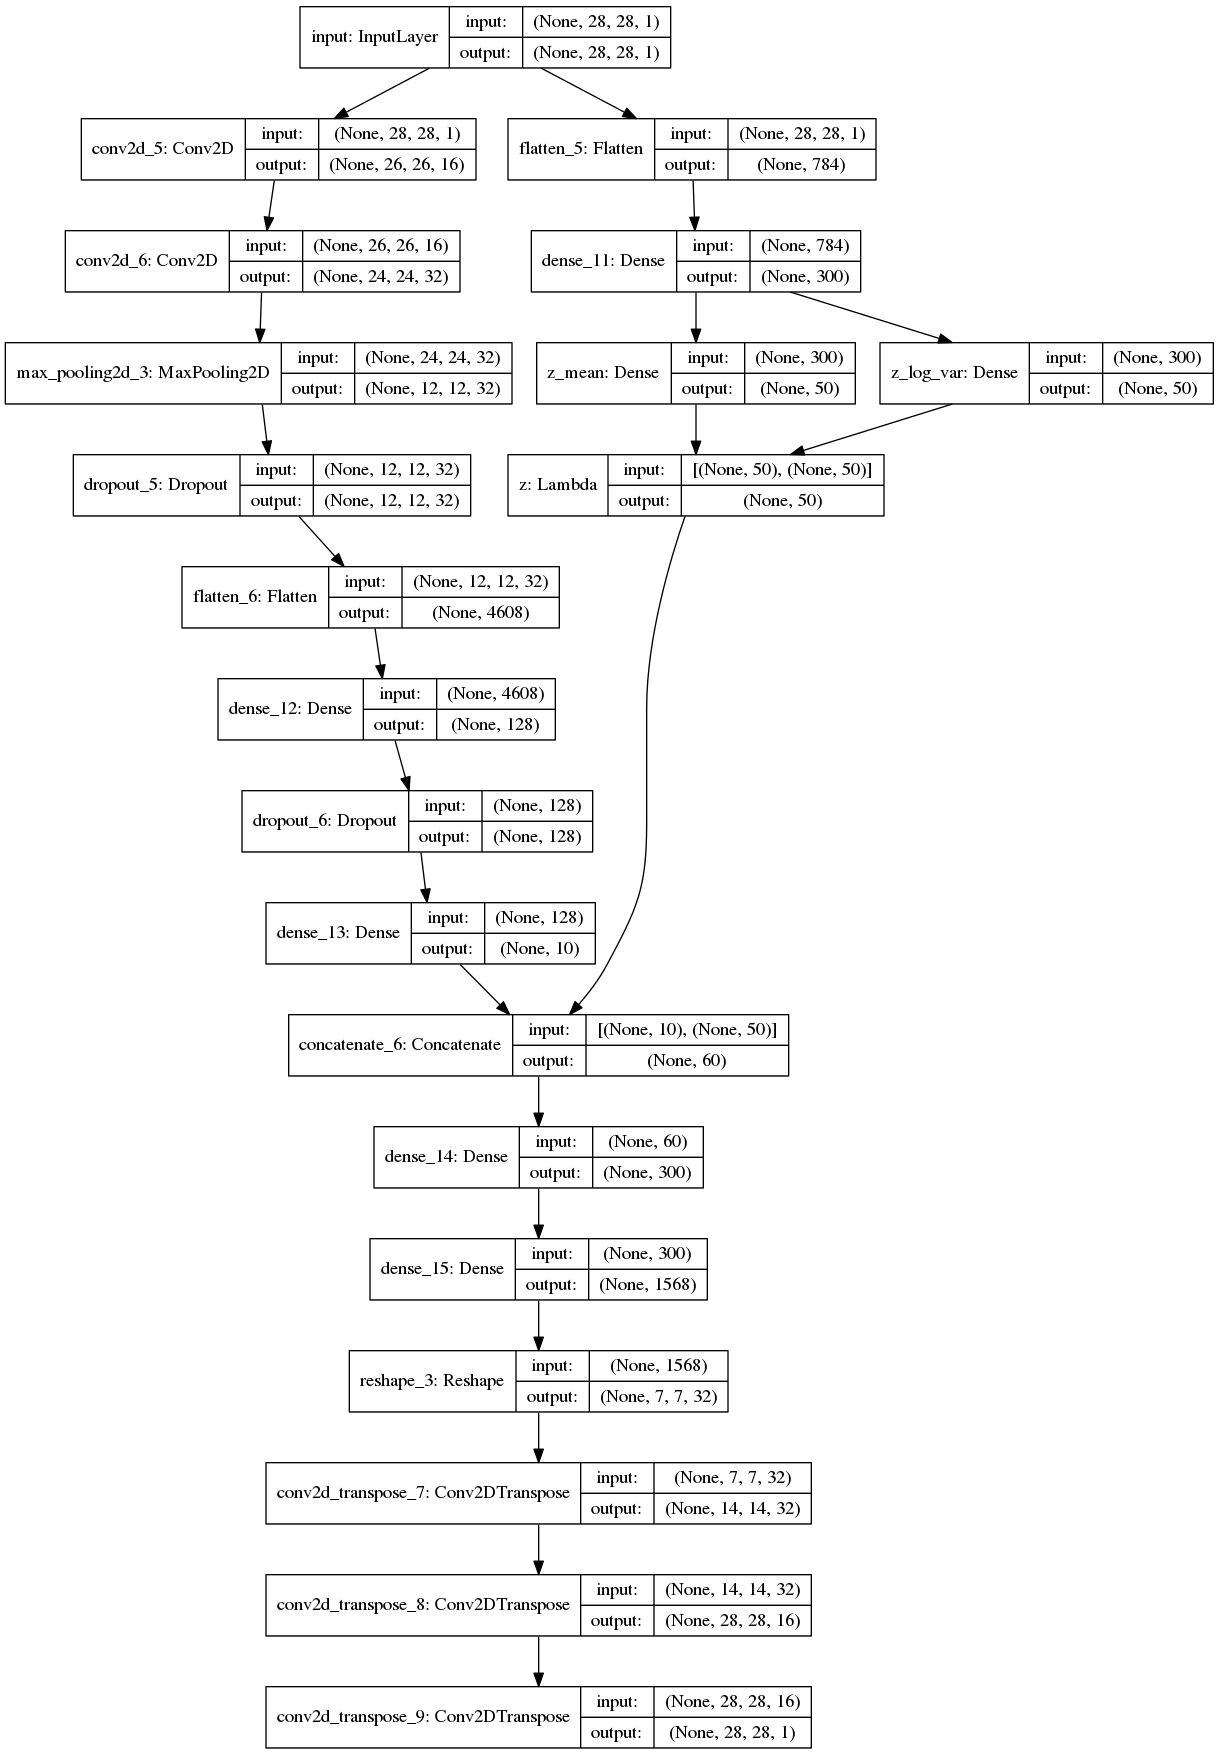

In [35]:
load_img('unlabel_c_vae_model.png')

## prepare training data (labeled / unlabeled)

In [36]:
num_samples = 10
x_labeled = []
y_labeled = []
x_unlabeled = []

for class_index in range(10):
    label_index = np.where(y_train == class_index)
    class_input_data = x_train[label_index]
    
    # labeled data
    x_labeled.append(class_input_data[:num_samples])
    y_labeled.append(np.full(num_samples, class_index, int))
    
    # unlabeled data
    x_unlabeled.append(class_input_data[num_samples:])
    
x_labeled = np.concatenate(x_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
x_labeled = x_labeled.astype('float32') / 255
x_unlabeled = x_unlabeled.astype('float32') / 255

x_labeled = x_labeled.reshape(x_labeled.shape+(1,))
x_unlabeled = x_unlabeled.reshape(x_unlabeled.shape+(1,))

y_labeled = np.concatenate(y_labeled, axis=0)
y_labeled_onehot = np.eye(num_classes)[y_labeled]


# test data
x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(x_test.shape+(1,))
y_test = np.eye(num_classes)[y_test]

In [37]:
print('labeled input_shape: {}, {}\nunlabeled input_shape: {}'.format(x_labeled.shape, y_labeled_onehot.shape, x_unlabeled.shape))
print('test input_shape: ', x_test.shape, y_test.shape)

labeled input_shape: (100, 28, 28, 1), (100, 10)
unlabeled input_shape: (59900, 28, 28, 1)
test input_shape:  (10000, 28, 28, 1) (10000, 10)


## まずは少量の教師あり(10ショット)学習

In [38]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               589952    
__________

In [39]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
history = classifier.fit(x_labeled, y_labeled_onehot, epochs=100, batch_size=batch_size, validation_data=(x_test, y_test))

Train on 100 samples, validate on 10000 samples
Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 2.3026 - acc: 0.1100 - val_loss: 2.2422 - val_acc: 0.3840
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2347 - acc: 0.2400 - val_loss: 2.1760 - val_acc: 0.5100
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 2.1008 - acc: 0.4300 - val_loss: 2.0955 - val_acc: 0.5527
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 2.0037 - acc: 0.5500 - val_loss: 1.9917 - val_acc: 0.5845
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8442 - acc: 0.5900 - val_loss: 1.8647 - val_acc: 0.6138
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6799 - acc: 0.6200 - val_loss: 1.7248 - val_acc: 0.6509
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 1.4973 - acc: 0.7100 - val_loss: 1.5796 - val_acc: 0.6740
Epoch 8/100
100/100 [

Epoch 62/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 1.4059 - val_acc: 0.7412
Epoch 63/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 1.4133 - val_acc: 0.7397
Epoch 64/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 1.4211 - val_acc: 0.7408
Epoch 65/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0221 - acc: 0.9900 - val_loss: 1.4201 - val_acc: 0.7423
Epoch 66/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0233 - acc: 1.0000 - val_loss: 1.4175 - val_acc: 0.7445
Epoch 67/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.4171 - val_acc: 0.7451
Epoch 68/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0184 - acc: 1.0000 - val_loss: 1.4199 - val_acc: 0.7468
Epoch 69/100
100/100 [==============================] - 0s 2ms

In [41]:
def plot_history(history):
    # 精度の履歴をプロット
    if 'acc' in history.history:
        plt.plot(history.history['acc'], "o-", label="accuracy")
        if 'val_acc' in history.history:
            plt.plot(history.history['val_acc'], "o-", label="validation_accuracy")
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1.05])
        plt.legend(loc="upper left")
        plt.show()

    # 損失の履歴をプロット
    if 'loss' in history.history:
        plt.plot(history.history['loss'],"o-",label="loss",)
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], "o-", label="val_loss")
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='lower right')
        plt.show()

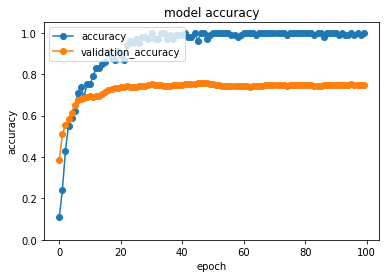

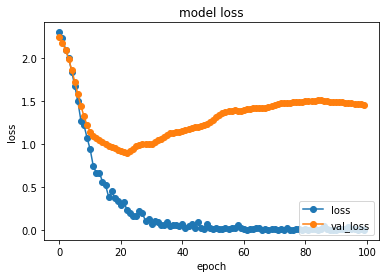

In [42]:
plot_history(history)

In [48]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [49]:
reset_weights(classifier)

## 半教師あり学習(semi-supervised learning)

In [50]:
# 教師なしの枚数が、教師ありと一致するようにリピート
labeled_index = []
for i in range(len(x_unlabeled) // len(x_labeled)):
    l = np.arange(len(x_labeled))
    np.random.shuffle(l)
    labeled_index.append(l)
labeled_index = np.concatenate(labeled_index)

#　教師ありのシャッフル
unlabeled_index = np.arange(len(x_unlabeled))

In [51]:
loss, validation_history = [], []
for epoch in range(epochs):
    print('epoch {}/{}'.format(epoch+1, epochs))
    np.random.shuffle(unlabeled_index)
    
    for i in range(steps_per_epoch-1):
        # print('step {}/ {}'.format(i+1, steps_per_epoch-1))
        # Labeled
        index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
        loss += labeled_vae.train_on_batch([x_labeled[index_range], y_labeled_onehot[index_range]], 
                                        [x_labeled[index_range], y_labeled_onehot[index_range]])

        # Unlabeled
        index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
        loss += unlabeled_vae.train_on_batch(x_unlabeled[index_range],  x_unlabeled[index_range])
        
    # final step
        
    # Labeled
    index_range =  labeled_index[(steps_per_epoch-1) * batch_size:]
    loss += labeled_vae.train_on_batch([x_labeled[index_range], y_labeled_onehot[index_range]], 
                                    [x_labeled[index_range], y_labeled_onehot[index_range]])

    # Unlabeled
    index_range =  unlabeled_index[(steps_per_epoch-1) * batch_size:]
    loss += unlabeled_vae.train_on_batch(x_unlabeled[index_range],  x_unlabeled[index_range])
    # validation accuracy
    history = classifier.evaluate(x_test, y_test)
    print(history)
    validation_history.append(history)

epoch 1/200
10000/10000 [==============================] - 1s 80us/step
[0.48650794270038605, 0.84709999999999996]
epoch 2/200
10000/10000 [==============================] - 1s 80us/step
[0.48173467157483102, 0.84960000000000002]
epoch 3/200
10000/10000 [==============================] - 1s 82us/step
[0.46377093563079835, 0.8508]
epoch 4/200
10000/10000 [==============================] - 1s 81us/step
[0.4635000187754631, 0.85909999999999997]
epoch 5/200
10000/10000 [==============================] - 1s 78us/step
[0.43928662001639607, 0.86329999999999996]
epoch 6/200
10000/10000 [==============================] - 1s 81us/step
[0.43834878055900334, 0.86499999999999999]
epoch 7/200
10000/10000 [==============================] - 1s 81us/step
[0.45036194447875022, 0.87690000000000001]
epoch 8/200
10000/10000 [==============================] - 1s 80us/step
[0.44021600965708496, 0.86160000000000003]
epoch 9/200
10000/10000 [==============================] - 1s 78us/step
[0.44954421006143092, 

10000/10000 [==============================] - 1s 83us/step
[0.27706839429046959, 0.92889999999999995]
epoch 73/200
10000/10000 [==============================] - 1s 81us/step
[0.30855650390358641, 0.9234]
epoch 74/200
10000/10000 [==============================] - 1s 77us/step
[0.2736803438410163, 0.93389999999999995]
epoch 75/200
10000/10000 [==============================] - 1s 82us/step
[0.29423185266405344, 0.92579999999999996]
epoch 76/200
10000/10000 [==============================] - 1s 79us/step
[0.29837849399484695, 0.92379999999999995]
epoch 77/200
10000/10000 [==============================] - 1s 79us/step
[0.2941622276203707, 0.92920000000000003]
epoch 78/200
10000/10000 [==============================] - 1s 80us/step
[0.28757973928898573, 0.92659999999999998]
epoch 79/200
10000/10000 [==============================] - 1s 82us/step
[0.29573239655978978, 0.92330000000000001]
epoch 80/200
10000/10000 [==============================] - 1s 81us/step
[0.28394698282554748, 0.933

10000/10000 [==============================] - 1s 81us/step
[0.25821213016132827, 0.93479999999999996]
epoch 144/200
10000/10000 [==============================] - 1s 81us/step
[0.27713528745719229, 0.92789999999999995]
epoch 145/200
10000/10000 [==============================] - 1s 80us/step
[0.29295226817703807, 0.92620000000000002]
epoch 146/200
10000/10000 [==============================] - 1s 80us/step
[0.27174353126220813, 0.9335]
epoch 147/200
10000/10000 [==============================] - 1s 81us/step
[0.27091803968301975, 0.93540000000000001]
epoch 148/200
10000/10000 [==============================] - 1s 80us/step
[0.2834971159876557, 0.93069999999999997]
epoch 149/200
10000/10000 [==============================] - 1s 79us/step
[0.29265135359945704, 0.92649999999999999]
epoch 150/200
10000/10000 [==============================] - 1s 83us/step
[0.29302140458241049, 0.93169999999999997]
epoch 151/200
10000/10000 [==============================] - 1s 79us/step
[0.299026233493362

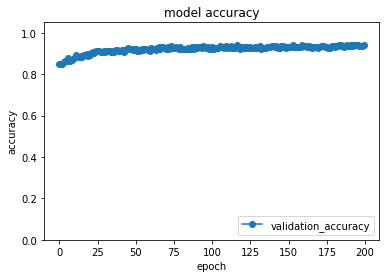

In [62]:
#plt.plot(np.array(validation_history).T[0])
plt.plot(np.array(validation_history).T[1], "o-", label="validation_accuracy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()